# Esercitazione 11

Elisa Stabilini - 942529

In [1]:
# importazione librerie
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
import string
from scipy.optimize import curve_fit
from numpy.lib.polynomial import poly

warnings.filterwarnings('ignore')
params = {'legend.fontsize': 'x-large', 'figure.figsize': (10, 6), 'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large', 'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import optimizers, losses, metrics

2022-08-29 07:25:40.646612: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-29 07:25:40.734439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 07:25:40.734462: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


L'obiettivo della esercitazione è capire come allenare una rete neurale (NN) ad eseguire dei fit.

## Esercizio 1

In questo esercizio si vuole esplorare come la regressione lineare della funzione $y(x)=2x+1$ dipende da:
* numero di epoche $N_{epochs}$
* numero di dati su cui viene eseguito il training della rete $N_{train}$
* quanto i dati vengono sporcati, cioè dal valore del parametro $\sigma$

Alla rete neurale vengono forniti, in fase di training dei punti distribuiti uniformemente, la rete effettuerà una regressione lineare e cercherà la funzione che meglio approssima la distribuzione di punti fornita.

**Inizializzo i parametri che deve trovare la rete neurale**

In [3]:
# target parameters of f(x) = m*x + b
m = 2 # pendenza
b = 1 # intercetta

**Generazione dei dati (training & validation)**

Per prima cosa vengono forniti alla rete i dati di training, in questo caso dei punti con ascissa $x_i$ e ordinata $y(x_i) + \sigma_i $, dove i $\sigma_i$ sono estratti da una distribuzione normale di varianza $\sigma$.
La rete neurale restituirà, per ogni $x_i$ una $f(x_i)$ dove la forma della $f$ dipende dall'architettura della rete neurale stessa. 
In questo caso, essendo il problema lineare, è sufficiente utilizzare un solo neurone infatati una qualunque legge del tipo $y=mx+q$ può essere espressa da un neurone con peso $m$, bias $q$ e funzione di attivazione lienare.

Ricordiamo che in generale la forma funzionale associata ad un neurone è del tipo $$ f_{w,b}(x) = wx +b $$ dove $w$ è il vettore dei pesi associati agli input $x_i$ e b è lo smearing con cui sono sporcati i dati.

In [4]:
np.random.seed(0)
N = [i*10**i for i in range(1,5)]
print(N)
x_train = [np.random.uniform(-1,1,N[i]) for i in range(len(N))]
x_valid = [np.random.uniform(-1,1, np.ceil(n*0.1).astype(int) + 5) for n in N]
x_target = np.random.uniform(-1,1,50)

sigma = np.array([0, 0.1, 0.25, 0.5]) #vaalori di sigma che sono utilizzati per generare lo smearing
y_train = [ [np.random.normal(m*x + b, s) for x in x_train] for s in sigma] 
y_valid = [ [np.random.normal(m*x + b, s) for x in x_valid] for s in sigma]
y_target = m*x_target + b #funzione target della rete neurale

[10, 200, 3000, 40000]


Nella porzione di codice precedente sono stati generati i dati per la fase di training e di validazione della rete neurale. I dati di validazione sono meno di quelli di training, generalmente fornito un dataset è sufficiente suddividerlo in maniera tale da riservare circa il 10% di dati per la validazione.

Per trovare la funzione che meglio rappresenta i dati la rete neurale deve minimizzare la distanza tra i valori prodotti dalla rete $(x_{train}, f_{wb}(x_{train,i})$ e i dati in ingresso $(x_{train}, y_{train,i})$; per valutare la differenza si utilizza lo scarto quadratico medio
$$ S(w,b) = \frac{1}{N}\sum_{i=1}^N (f_{w,b}(x_{train,i}) - y_{train,i})^2 
$$
Per la ricerca del minimo in questo caso viene utilizzato l'algoritmo di *stochastic gradient descent (SDG)* implementato da Keras.

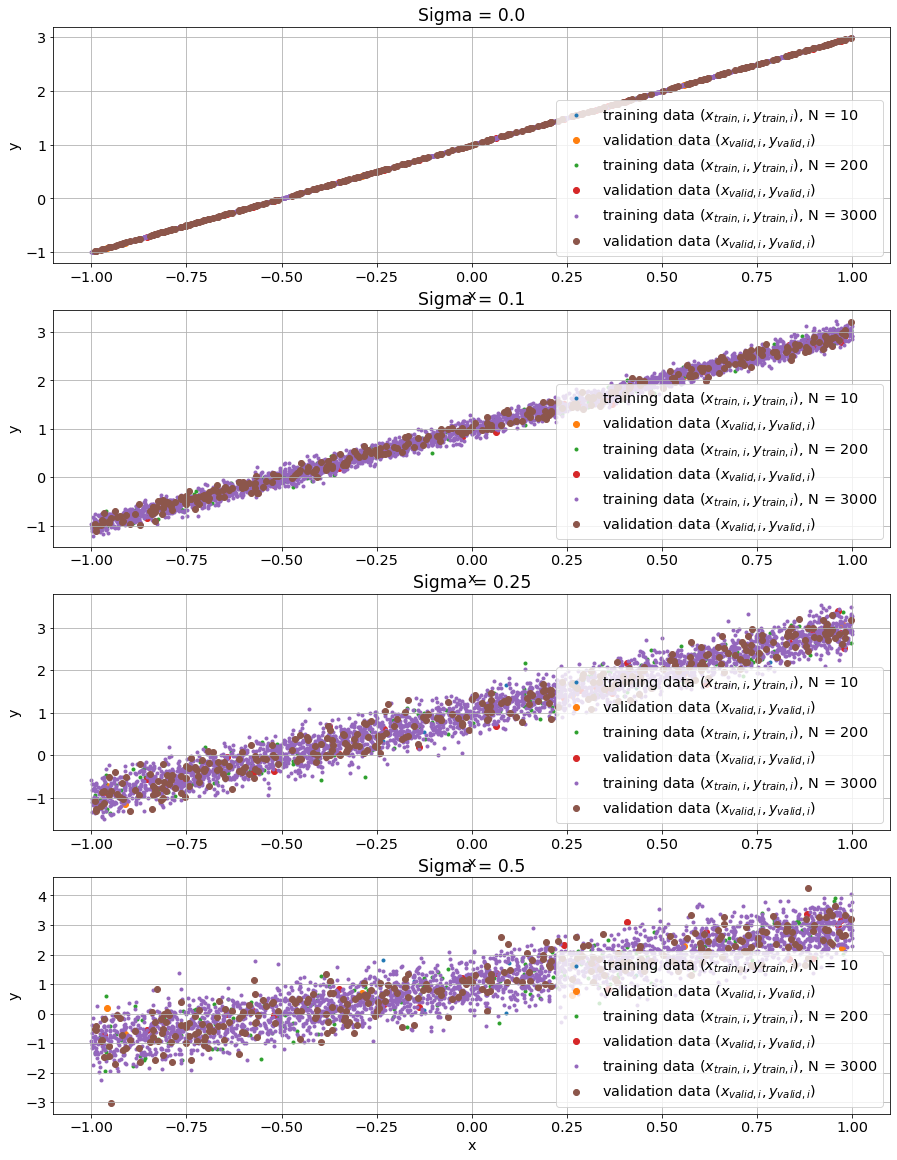

In [5]:
# plot validation and target dataset

fig, plts = plt.subplots(sigma.size,1)
for i in range(sigma.size):
    for j in range(len(x_train)-1):
        plts[i].scatter(x_train[j], y_train[i][j], marker = '.',  label='training data ($x_{train,i}, y_{train,i}$), N = ' + str(x_train[j].size))
        plts[i].scatter(x_valid[j], y_valid[i][j], label='validation data $(x_{valid,i},y_{valid,i})$')
    plts[i].set_xlabel("x")
    plts[i].set_ylabel("y")
    plts[i].legend()
    plts[i].grid(True)
    plts[i].set_title('Sigma = ' + str(sigma[i]))

fig.set_figwidth(15)
fig.set_figheight(5*sigma.size)

In [6]:
#creo il modello che deve studiare i dati
model = [ [tf.keras.Sequential() for j in range(len(x_train))] for i in range(sigma.size) ]
for i in range(sigma.size):
    for j in range(len(x_train)):
        model[i][j].add(Dense(1, input_shape=(1,))) #aggiungo il singolo neurone che ha come input un solo parametro
        sgd = optimizers.SGD(learning_rate=0.01, momentum=0.0, decay=0.0, nesterov=False) #stocahstic gradient descent
        model[i][j].compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])# compilo il modello    

2022-08-29 07:27:18.323638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 07:27:18.323929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 07:27:18.323969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-29 07:27:18.323997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-29 07:27:18.324024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [7]:
# get a summary of our composed model
model[0][0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Dal *riassunto* sopra vediamo che il modello ha due parametri, entrambi da ottimizzare. Esattamente come mi aspetto in una rete con un solo neurone per fitatre una funzione lineare.
Ora alleno il modello per 30 epoche, il numero di batch ad ogni epoca è fissato a 10.

In [8]:
# fit the model using training dataset
# over 30 epochs of their own batch size each
# report training progress against validation data
batches = [(i+1)*10**i for i in range(0,4)]
print(batches)
history = [ [model[i][j].fit(x=x_train[j], y=y_train[i][j],
                             batch_size=batches[j],
                             epochs=30,
                             shuffle=True,
                             validation_data=(x_valid[j], y_valid[i][j]) ) for j in range(len(x_train))] for i in range(sigma.size) ]

[1, 20, 300, 4000]
Epoch 1/30
10/10 [==============================] - 0s 8ms/step - loss: 1.2958 - mse: 1.2958 - val_loss: 0.8660 - val_mse: 0.8660
Epoch 2/30
10/10 [==============================] - 0s 2ms/step - loss: 0.8548 - mse: 0.8548 - val_loss: 0.5943 - val_mse: 0.5943
Epoch 3/30
10/10 [==============================] - 0s 2ms/step - loss: 0.5673 - mse: 0.5673 - val_loss: 0.4205 - val_mse: 0.4205
Epoch 4/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3808 - mse: 0.3808 - val_loss: 0.3098 - val_mse: 0.3098
Epoch 5/30
10/10 [==============================] - 0s 2ms/step - loss: 0.2596 - mse: 0.2596 - val_loss: 0.2383 - val_mse: 0.2383
Epoch 6/30
10/10 [==============================] - 0s 2ms/step - loss: 0.1795 - mse: 0.1795 - val_loss: 0.1917 - val_mse: 0.1917
Epoch 7/30
10/10 [==============================] - 0s 2ms/step - loss: 0.1267 - mse: 0.1267 - val_loss: 0.1613 - val_mse: 0.1613
Epoch 8/30
10/10 [==============================] - 0s 2ms/step - loss:

Epoch 6/30
10/10 [==============================] - 0s 2ms/step - loss: 0.8348 - mse: 0.8348 - val_loss: 2.2596 - val_mse: 2.2596
Epoch 7/30
10/10 [==============================] - 0s 2ms/step - loss: 0.7087 - mse: 0.7087 - val_loss: 2.1378 - val_mse: 2.1378
Epoch 8/30
10/10 [==============================] - 0s 2ms/step - loss: 0.6197 - mse: 0.6197 - val_loss: 2.0319 - val_mse: 2.0319
Epoch 9/30
10/10 [==============================] - 0s 2ms/step - loss: 0.5541 - mse: 0.5541 - val_loss: 1.9330 - val_mse: 1.9330
Epoch 10/30
10/10 [==============================] - 0s 2ms/step - loss: 0.5050 - mse: 0.5050 - val_loss: 1.8439 - val_mse: 1.8439
Epoch 11/30
10/10 [==============================] - 0s 3ms/step - loss: 0.4649 - mse: 0.4649 - val_loss: 1.7585 - val_mse: 1.7585
Epoch 12/30
10/10 [==============================] - 0s 3ms/step - loss: 0.4318 - mse: 0.4318 - val_loss: 1.6773 - val_mse: 1.6773
Epoch 13/30
10/10 [==============================] - 0s 2ms/step - loss: 0.4035 - mse: 

Epoch 9/30
10/10 [==============================] - 0s 2ms/step - loss: 0.4313 - mse: 0.4313 - val_loss: 0.3891 - val_mse: 0.3891
Epoch 10/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3703 - mse: 0.3703 - val_loss: 0.3353 - val_mse: 0.3353
Epoch 11/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3195 - mse: 0.3195 - val_loss: 0.2901 - val_mse: 0.2901
Epoch 12/30
10/10 [==============================] - 0s 2ms/step - loss: 0.2767 - mse: 0.2767 - val_loss: 0.2517 - val_mse: 0.2517
Epoch 13/30
10/10 [==============================] - 0s 2ms/step - loss: 0.2405 - mse: 0.2405 - val_loss: 0.2190 - val_mse: 0.2190
Epoch 14/30
10/10 [==============================] - 0s 2ms/step - loss: 0.2097 - mse: 0.2097 - val_loss: 0.1909 - val_mse: 0.1909
Epoch 15/30
10/10 [==============================] - 0s 2ms/step - loss: 0.1832 - mse: 0.1832 - val_loss: 0.1667 - val_mse: 0.1667
Epoch 16/30
10/10 [==============================] - 0s 2ms/step - loss: 0.1604 - ms

Epoch 12/30
10/10 [==============================] - 0s 2ms/step - loss: 0.5793 - mse: 0.5793 - val_loss: 1.8861 - val_mse: 1.8861
Epoch 13/30
10/10 [==============================] - 0s 2ms/step - loss: 0.5467 - mse: 0.5467 - val_loss: 1.7931 - val_mse: 1.7931
Epoch 14/30
10/10 [==============================] - 0s 2ms/step - loss: 0.5184 - mse: 0.5184 - val_loss: 1.7029 - val_mse: 1.7029
Epoch 15/30
10/10 [==============================] - 0s 2ms/step - loss: 0.4939 - mse: 0.4939 - val_loss: 1.6196 - val_mse: 1.6196
Epoch 16/30
10/10 [==============================] - 0s 2ms/step - loss: 0.4701 - mse: 0.4701 - val_loss: 1.5394 - val_mse: 1.5394
Epoch 17/30
10/10 [==============================] - 0s 2ms/step - loss: 0.4482 - mse: 0.4482 - val_loss: 1.4605 - val_mse: 1.4605
Epoch 18/30
10/10 [==============================] - 0s 2ms/step - loss: 0.4286 - mse: 0.4286 - val_loss: 1.3880 - val_mse: 1.3880
Epoch 19/30
10/10 [==============================] - 0s 2ms/step - loss: 0.4098 - m

Epoch 17/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3677 - mse: 0.3677 - val_loss: 0.2174 - val_mse: 0.2174
Epoch 18/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3671 - mse: 0.3671 - val_loss: 0.2176 - val_mse: 0.2176
Epoch 19/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3666 - mse: 0.3666 - val_loss: 0.2181 - val_mse: 0.2181
Epoch 20/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3662 - mse: 0.3662 - val_loss: 0.2186 - val_mse: 0.2186
Epoch 21/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3658 - mse: 0.3658 - val_loss: 0.2190 - val_mse: 0.2190
Epoch 22/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3656 - mse: 0.3656 - val_loss: 0.2194 - val_mse: 0.2194
Epoch 23/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3654 - mse: 0.3654 - val_loss: 0.2193 - val_mse: 0.2193
Epoch 24/30
10/10 [==============================] - 0s 2ms/step - loss: 0.3652 - m

**Stampo i riusltati ottenuti dalla rete neurale**

In [9]:
# return weights and biases
for i in range(sigma.size): #suddivido i risultati in base all'ampiezza dello smearing che uso
    print('Sigma = '  + str(sigma[i])) #mostro quale peso sto utilizzando per lo smearing
    for j in range(len(x_train)):
        print('  Ntr = ' + str(10**(j+1))) #numero di dati di training
        print('   w = ' +  str(model[i][j].get_weights()[0]) + ' - atteso: ' + str(2)) #coefficiente angolare (in questo caso coincide con il peso) 
        print('   b = ' +  str(model[i][j].get_weights()[1]) + ' - atteso: ' + str(1)) #intercetta (in questo caso coincide con il bias)

Sigma = 0.0
  Ntr = 10
   w = [[1.7406381]] - atteso: 2
   b = [1.0672321] - atteso: 1
  Ntr = 100
   w = [[1.7102289]] - atteso: 2
   b = [0.9900015] - atteso: 1
  Ntr = 1000
   w = [[1.8154206]] - atteso: 2
   b = [1.0000666] - atteso: 1
  Ntr = 10000
   w = [[1.6852539]] - atteso: 2
   b = [0.9951834] - atteso: 1
Sigma = 0.1
  Ntr = 10
   w = [[0.93976265]] - atteso: 2
   b = [1.253619] - atteso: 1
  Ntr = 100
   w = [[1.5428873]] - atteso: 2
   b = [0.9764657] - atteso: 1
  Ntr = 1000
   w = [[1.760447]] - atteso: 2
   b = [1.0024357] - atteso: 1
  Ntr = 10000
   w = [[1.6756194]] - atteso: 2
   b = [0.9959446] - atteso: 1
Sigma = 0.25
  Ntr = 10
   w = [[0.9640606]] - atteso: 2
   b = [1.2382324] - atteso: 1
  Ntr = 100
   w = [[1.8343233]] - atteso: 2
   b = [0.97089684] - atteso: 1
  Ntr = 1000
   w = [[1.7448813]] - atteso: 2
   b = [1.0043498] - atteso: 1
  Ntr = 10000
   w = [[1.739315]] - atteso: 2
   b = [0.9986922] - atteso: 1
Sigma = 0.5
  Ntr = 10
   w = [[1.3629096]] - 

**Valuto le performance del modello**

Utilizzando i metodi di Keras valuto la *loss function* sui dati di validazione generati all'inizio, ovvero gli stessi che sono stati utilizzati durante l'addestramento per valutare la *validation loss function*.

In [10]:
# evaluate model
score_tar = [[model[i][j].evaluate(x_target, y_target, batch_size=batches[j], verbose=1) for j in range(len(x_train)) ] for i in range(sigma.size)]

# print performance
print()
for i in range(sigma.size):
  print('Sigma = ' + str(sigma[i]))
  for j in range(len(x_train)):
    print('  N = ' + str(x_train[j].size))
    print('    Test loss:', score_tar[i][j][0])


1/1 [==============================] - 0s 10ms/step - loss: 0.0113 - mse: 0.0113

Sigma = 0.0
  N = 10
    Test loss: 0.033103249967098236
  N = 200
    Test loss: 0.031496576964855194
  N = 3000
    Test loss: 0.012945344671607018
  N = 40000
    Test loss: 0.03739537298679352
Sigma = 0.1
  N = 10
    Test loss: 0.538059651851654
  N = 200
    Test loss: 0.07806812971830368
  N = 3000
    Test loss: 0.021908340975642204
  N = 40000
    Test loss: 0.039762772619724274
Sigma = 0.25
  N = 10
    Test loss: 0.5073047876358032
  N = 200
    Test loss: 0.010437807999551296
  N = 3000
    Test loss: 0.024937938898801804
  N = 40000
    Test loss: 0.02575961872935295
Sigma = 0.5
  N = 10
    Test loss: 0.16222301125526428
  N = 200
    Test loss: 0.006195171270519495
  N = 3000
    Test loss: 0.0013347524218261242
  N = 40000
    Test loss: 0.011306066066026688


**Plot dei risultati**

Nei grafici di seguito mostro come varia la *loss function* al variare di $N$ e $\sigma$.

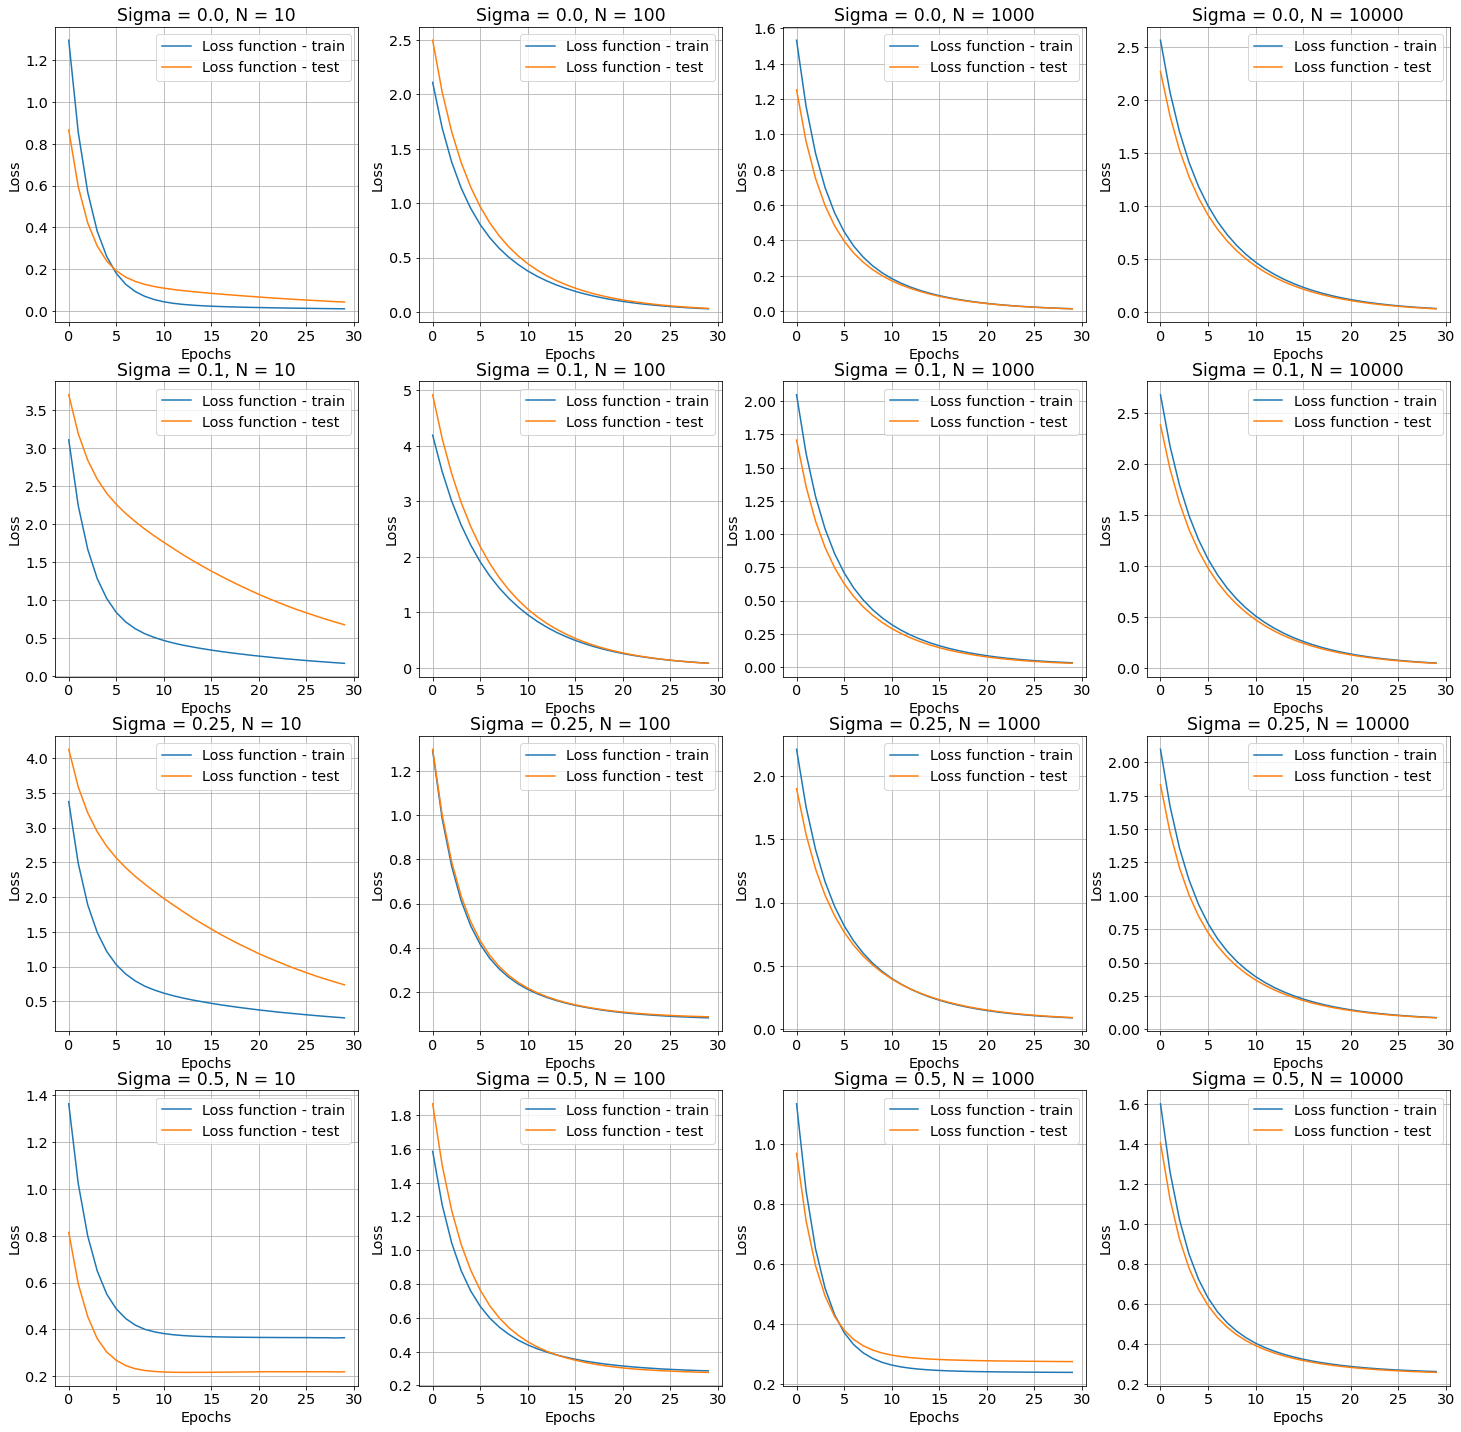

In [11]:
fig, plts = plt.subplots(sigma.size, len(x_train))
for i in range(sigma.size):
      for j in range(len(x_train)):
            plts[i][j].plot(history[i][j].history['loss'])
            plts[i][j].plot(history[i][j].history['val_loss'])
            plts[i][j].legend(['Loss function - train', 'Loss function - test'], loc='best')
            plts[i][j].grid(True)
            plts[i][j].set_ylabel('Loss')
            plts[i][j].set_xlabel('Epochs')
            plts[i][j].set_title('Sigma = ' + str(sigma[i]) + ', N = ' + str(10**(j+1)) )

fig.set_figwidth(25)
fig.set_figheight(25)

Osserviamo ora per ciascuna rete neurale qual'è la predzìizione e confrontiamo il risultato con il modello.

4/4 [==============================] - 0s 818us/step


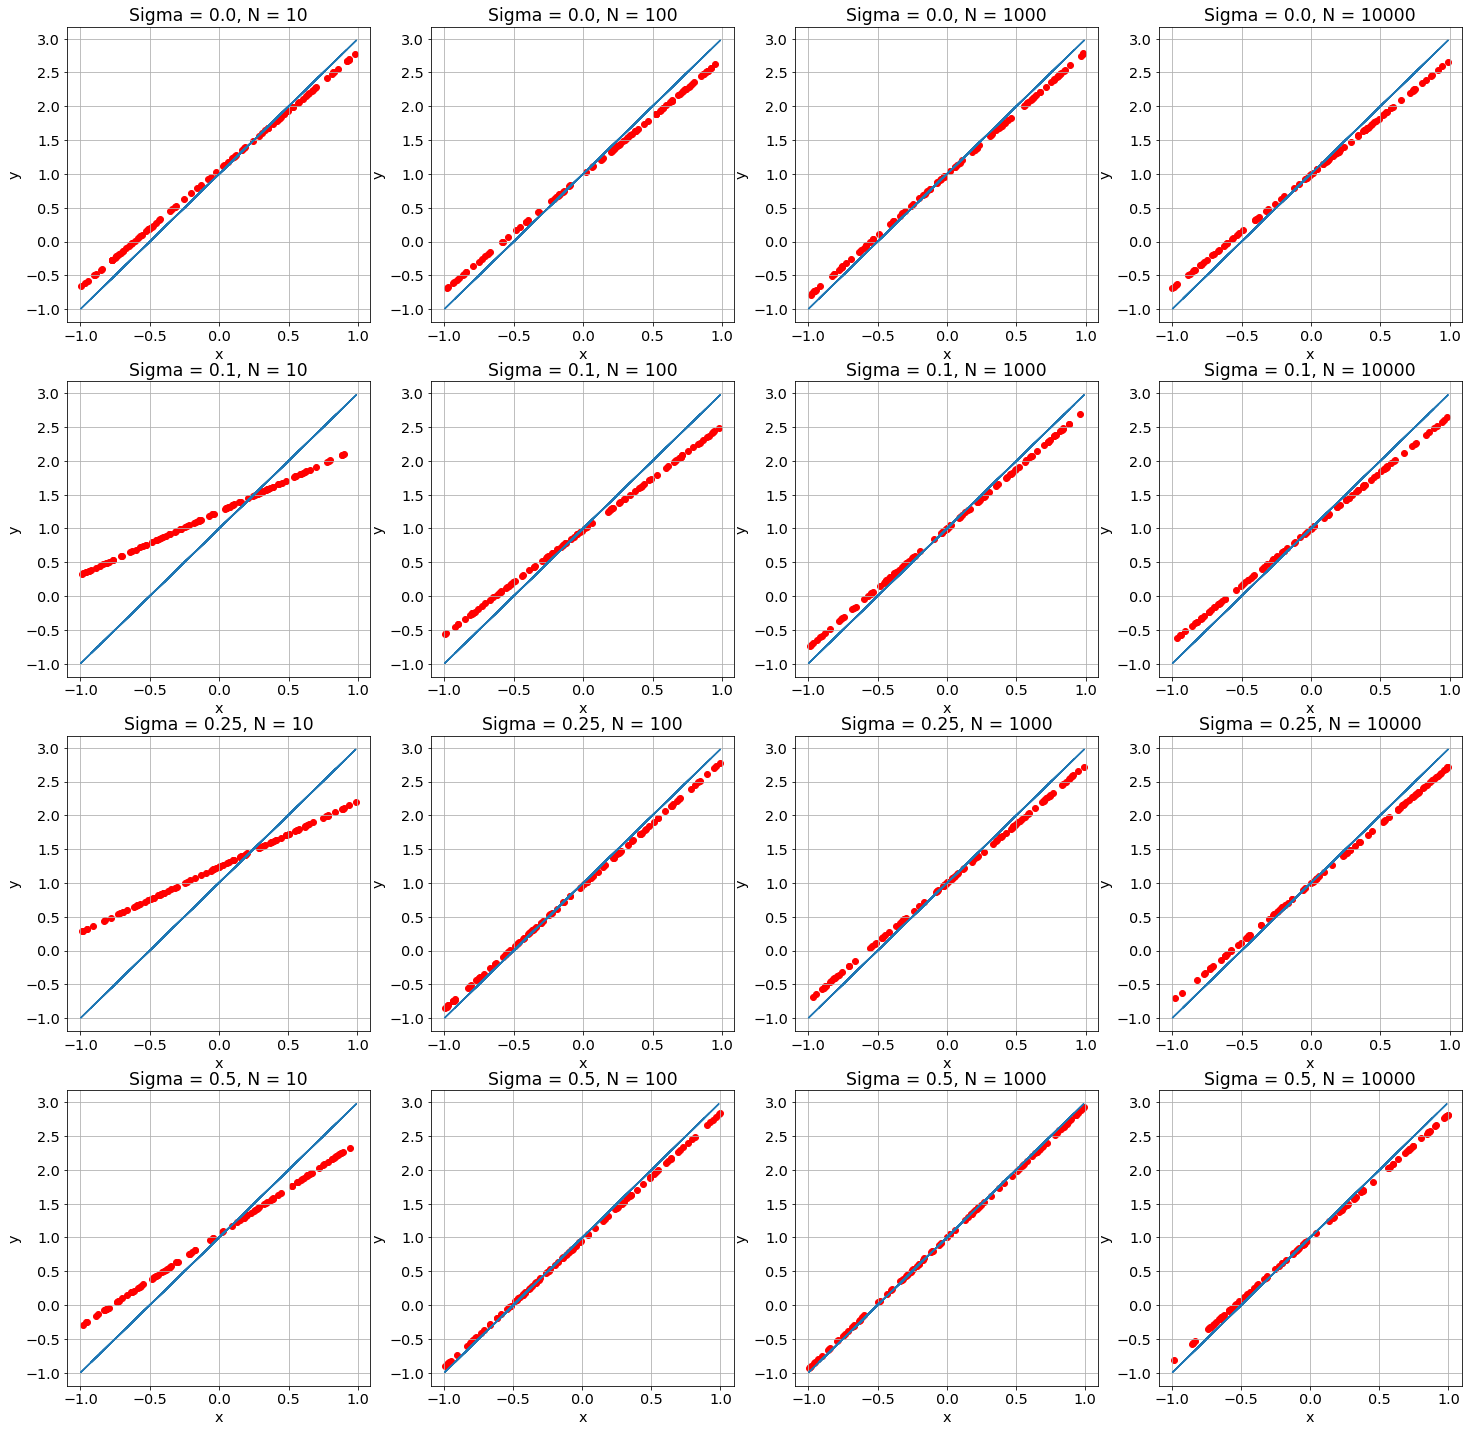

In [12]:
fig, plts = plt.subplots(sigma.size, len(x_train))

for i in range(sigma.size):
    for j in range(len(N)):
        x_predicted = np.random.uniform(-1, 1, 100)
        y_predicted = model[i][j].predict(x_predicted)
        plts[i][j].scatter(x_predicted, y_predicted,color='r')
        plts[i][j].plot(x_target, y_target)
        plts[i][j].grid(True)
        plts[i][j].set_title('Sigma = ' + str(sigma[i]) + ', N = ' + str(10**(j+1)) )
        plts[i][j].set_xlabel('x')
        plts[i][j].set_ylabel('y')
fig.set_figwidth(25)
fig.set_figheight(25)

## Esercizio 2

L'obiettivo di questo esercizio è quello di estendere la rete neurale costruita precedentemente perchè esegua il *fit* di dati distribuiti secondo la seguente legge polinomiale:
$$ g(x) = 4-3x-2x^2+3x^3, $$
con $x \in [-1,1]$.

**Genero i dati di training**

In [13]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1,1,10000) #Training inputs of (10, 100, 1000) points
x_valid = np.random.uniform(-1,1,100) #Validazione: 10% rispetto ai dati di training
x_valid.sort()
x_target = np.random.uniform(-1,1,100)
x_target.sort()

sigma = 0.1 # noise standard deviation
y_train = np.random.normal(4 - 3*x_train - 2*x_train**2 + 3*x_train**3, sigma) #training: cerco i parametri
y_valid = np.random.normal(4 - 3*x_valid - 2*x_valid**2 + 3*x_valid**3, sigma) #validation: valuto i parametri trovati
y_target = 4 - 3*x_target - 2*x_target**2 + 3*x_target**3 #funzione target

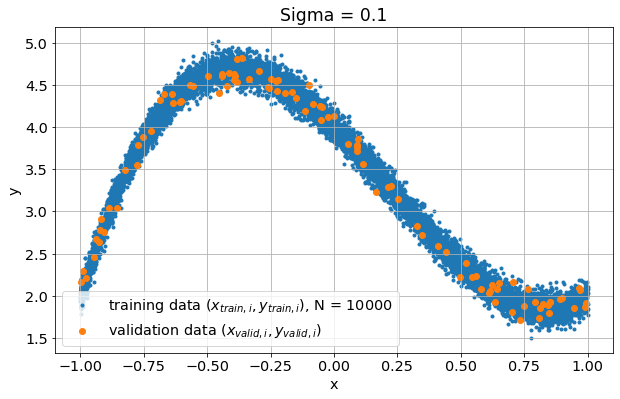

In [14]:
from numpy.lib.polynomial import poly
# plot validation and target dataset
import matplotlib.pyplot as plt

plt.scatter(x_train, y_train, marker = '.',  label='training data ($x_{train,i}, y_{train,i}$), N = 10000')
plt.scatter(x_valid, y_valid, label='validation data $(x_{valid,i},y_{valid,i})$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('Sigma = ' + str(sigma))

fig.set_figwidth(15)
fig.set_figheight(5*1)

**Testo le funzioni di attivazione per i neuroni**

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

act_func = ['tanh', 'sigmoid', 'relu', 'elu']
model = [tf.keras.Sequential(  
    [
        Dense(2, activation=fun, input_shape=(1,)), 
        Dense(1, activation=None )
    ]
) for fun in act_func]

sgd = optimizers.SGD(learning_rate=0.01, momentum=0.0, decay=0.0, nesterov=False) #stocahstich gradient descent
for m in model:
    m.compile(optimizer=sgd, loss='mse', metrics=['mse'])
    
model[0].summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 2)                 4         
                                                                 
 dense_17 (Dense)            (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [16]:
history2 = [ m.fit(x=x_train, y=y_train,
                             batch_size=16,
                             epochs=20,
                             shuffle=True,
                             validation_data=(x_valid, y_valid) ) for m in model]

Epoch 1/20
625/625 [==============================] - 0s 539us/step - loss: 1.1107 - mse: 1.1107 - val_loss: 0.4143 - val_mse: 0.4143
Epoch 2/20
625/625 [==============================] - 0s 459us/step - loss: 0.2406 - mse: 0.2406 - val_loss: 0.1556 - val_mse: 0.1556
Epoch 3/20
625/625 [==============================] - 0s 455us/step - loss: 0.0908 - mse: 0.0908 - val_loss: 0.0702 - val_mse: 0.0702
Epoch 4/20
625/625 [==============================] - 0s 452us/step - loss: 0.0523 - mse: 0.0523 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 5/20
625/625 [==============================] - 0s 449us/step - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 6/20
625/625 [==============================] - 0s 473us/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 7/20
625/625 [==============================] - 0s 467us/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 8/20
625/625 [==============================] - 0s 465us

Epoch 2/20
625/625 [==============================] - 0s 444us/step - loss: 0.4125 - mse: 0.4125 - val_loss: 0.4782 - val_mse: 0.4782
Epoch 3/20
625/625 [==============================] - 0s 453us/step - loss: 0.3934 - mse: 0.3934 - val_loss: 0.4699 - val_mse: 0.4699
Epoch 4/20
625/625 [==============================] - 0s 445us/step - loss: 0.3888 - mse: 0.3888 - val_loss: 0.4648 - val_mse: 0.4648
Epoch 5/20
625/625 [==============================] - 0s 449us/step - loss: 0.3850 - mse: 0.3850 - val_loss: 0.4632 - val_mse: 0.4632
Epoch 6/20
625/625 [==============================] - 0s 452us/step - loss: 0.3817 - mse: 0.3817 - val_loss: 0.4547 - val_mse: 0.4547
Epoch 7/20
625/625 [==============================] - 0s 462us/step - loss: 0.3769 - mse: 0.3769 - val_loss: 0.4511 - val_mse: 0.4511
Epoch 8/20
625/625 [==============================] - 0s 453us/step - loss: 0.3707 - mse: 0.3707 - val_loss: 0.4419 - val_mse: 0.4419
Epoch 9/20
625/625 [==============================] - 0s 448us

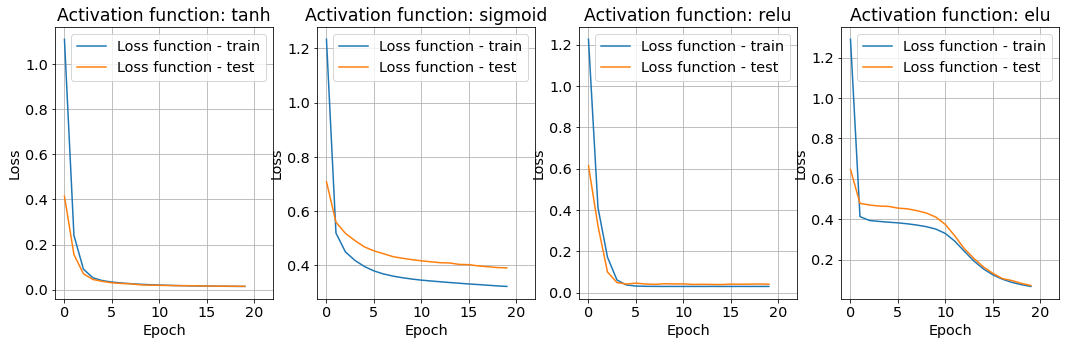

In [17]:
fig, plts = plt.subplots(1, len(act_func))

for j in range(len(act_func)):
    plts[j].plot(history2[j].history['loss'])
    plts[j].plot(history2[j].history['val_loss'])
    plts[j].legend(['Loss function - train', 'Loss function - test'], loc='best')
    plts[j].grid(True)
    plts[j].set_ylabel('Loss')
    plts[j].set_xlabel('Epoch')
    plts[j].set_xlim((-1,22))
    plts[j].set_title('Activation function: ' + str(act_func[j]))
    
fig.set_figwidth(18)
fig.set_figheight(5)

Guardando i grafici si osserva che la funzione di attivazione più adatta a fittare una fuzione polinomiale, utilizzando solo pochi neuroni è la sigmoide, che tuttavia non offre delle ottime prestazioni. Per questo motivo provo ad aumentare il numero di neuroni.

In [18]:
model = [tf.keras.Sequential(
    [
        Dense(10, activation = fun, input_shape=(1,) ),
        Dense(1, activation = None ),
    ]
) for fun in act_func]

for m in model:
    m.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01), loss='mse', metrics=['mse'])

model[0].summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                20        
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [19]:
history3 = [ m.fit(x=x_train, y=y_train,
                             batch_size=16,
                             epochs=20,
                             shuffle=True,
                             validation_data=(x_valid, y_valid) ) for m in model]

Epoch 1/20
625/625 [==============================] - 0s 548us/step - loss: 0.5748 - mse: 0.5748 - val_loss: 0.3701 - val_mse: 0.3701
Epoch 2/20
625/625 [==============================] - 0s 458us/step - loss: 0.2296 - mse: 0.2296 - val_loss: 0.1971 - val_mse: 0.1971
Epoch 3/20
625/625 [==============================] - 0s 455us/step - loss: 0.1245 - mse: 0.1245 - val_loss: 0.0963 - val_mse: 0.0963
Epoch 4/20
625/625 [==============================] - 0s 460us/step - loss: 0.0676 - mse: 0.0676 - val_loss: 0.0599 - val_mse: 0.0599
Epoch 5/20
625/625 [==============================] - 0s 508us/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 6/20
625/625 [==============================] - 0s 462us/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 7/20
625/625 [==============================] - 0s 465us/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 8/20
625/625 [==============================] - 0s 466us

Epoch 2/20
625/625 [==============================] - 0s 478us/step - loss: 0.5207 - mse: 0.5207 - val_loss: 0.5449 - val_mse: 0.5449
Epoch 3/20
625/625 [==============================] - 0s 460us/step - loss: 0.3667 - mse: 0.3667 - val_loss: 0.3252 - val_mse: 0.3252
Epoch 4/20
625/625 [==============================] - 0s 451us/step - loss: 0.2108 - mse: 0.2108 - val_loss: 0.1922 - val_mse: 0.1922
Epoch 5/20
625/625 [==============================] - 0s 474us/step - loss: 0.1410 - mse: 0.1410 - val_loss: 0.1352 - val_mse: 0.1352
Epoch 6/20
625/625 [==============================] - 0s 464us/step - loss: 0.1068 - mse: 0.1068 - val_loss: 0.1054 - val_mse: 0.1054
Epoch 7/20
625/625 [==============================] - 0s 472us/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 8/20
625/625 [==============================] - 0s 467us/step - loss: 0.0748 - mse: 0.0748 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 9/20
625/625 [==============================] - 0s 465us

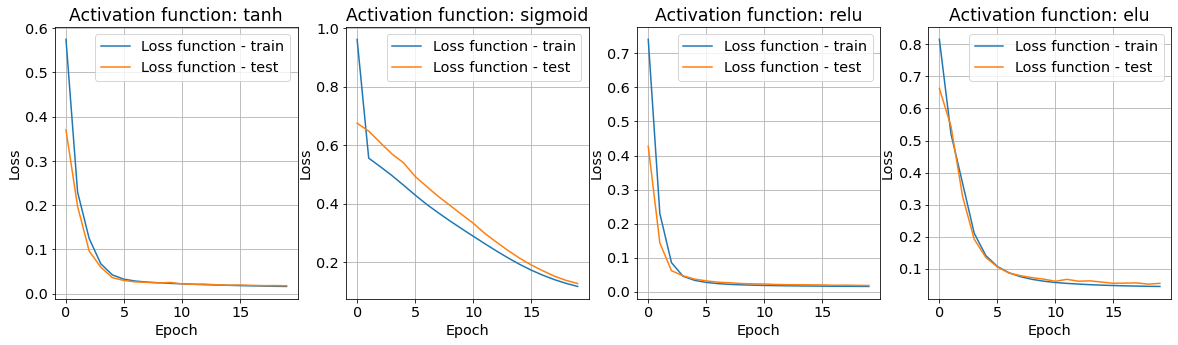

In [21]:
fig, plts = plt.subplots(1, len(act_func))

for j in range(len(act_func)):
    plts[j].plot(history3[j].history['loss'])
    plts[j].plot(history3[j].history['val_loss'])
    plts[j].legend(['Loss function - train', 'Loss function - test'], loc='best')
    plts[j].grid(True)
    plts[j].set_ylabel('Loss')
    plts[j].set_xlabel('Epoch')
    plts[j].set_title('Activation function: ' + str(act_func[j]))
    
fig.set_figwidth(20)
fig.set_figheight(5)

Provo a guardare più nel dettaglio le performance dei diversi modelli di rete neurale ovvero qual è la funzione di attivazione che meglio consente alla rete di fittare una funzione polinomiale.

In [22]:
scores3 = [m.evaluate(x_valid, y_valid, batch_size=16, verbose=1) for m in model]

for i in range(len(act_func)):
    print('Activation function: ' + str(act_func[i]))
    print(' Test loss = ' + str(scores3[i][0]) )

7/7 [==============================] - 0s 710us/step - loss: 0.0543 - mse: 0.0543
Activation function: tanh
 Test loss = 0.018034540116786957
Activation function: sigmoid
 Test loss = 0.1276898980140686
Activation function: relu
 Test loss = 0.01809043437242508
Activation function: elu
 Test loss = 0.05427270010113716


4/4 [==============================] - 0s 639us/step


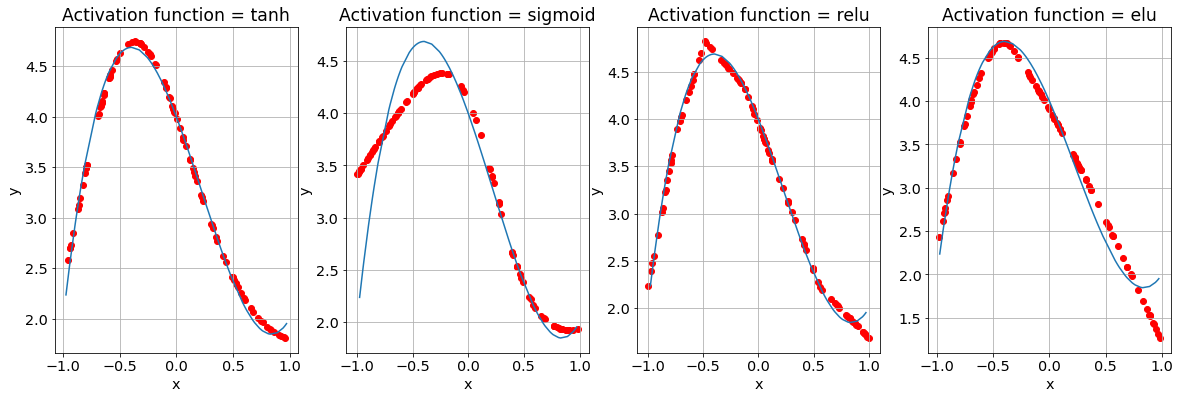

In [24]:
fig, plts = plt.subplots(1, len(act_func))

for i in range(len(act_func)):
    x_predicted = np.random.uniform(-1, 1, 100)
    y_predicted = model[i].predict(x_predicted).reshape(100)
    plts[i].scatter(x_predicted, y_predicted,color='r')
    plts[i].plot(x_target, y_target)
    plts[i].grid(True)
    plts[i].set_title('Activation function = ' + str(act_func[i]))
    plts[i].set_xlabel('x')
    plts[i].set_ylabel('y')

fig.set_figwidth(20)

Si osserva quindi che la funzione di attivazione che offre le migliori prestazioni nel caso di fit polinomiale è la tangente iperbolica. Questo risultato non è del tutto inatteso infatti le funzioni di attivazione *relu* ed *elu* sono entrambe lineari per $x$ positive è ragionevole quindi che una loro combinazione lineare non sia adatta a restituire il fit di un polinomio di terzo grado. Per quanto riguarda la differenza di predizione per le reti con queste due funzioni di attivazione che si osserva per $x$ negative dipende dal fatto che la *relu* è lineare anche per $x$ negative mentre la *elu*, avendo un andamento esponenziale per $x$ negative ha un comportamento migliore (almeno all'interno di questo intervallo di lavoro).

4/4 [==============================] - 0s 879us/step


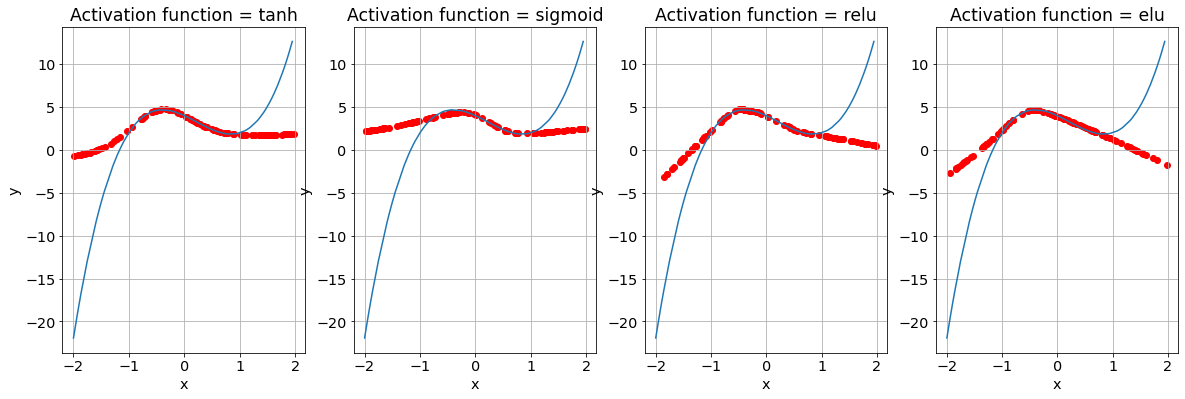

In [26]:
fig, plts = plt.subplots(1, len(act_func))
x_target = np.random.uniform(-2,2,100)
x_target.sort()
y_target = 4 - 3*x_target - 2*x_target**2 + 3*x_target**3

for i in range(len(act_func)):
    x_predicted = np.random.uniform(-2, 2, 100)
    y_predicted = model[i].predict(x_predicted).reshape(100)
    plts[i].scatter(x_predicted, y_predicted,color='r')
    plts[i].plot(x_target, y_target)
    plts[i].grid(True)
    plts[i].set_title('Activation function = ' + str(act_func[i]))
    plts[i].set_xlabel('x')
    plts[i].set_ylabel('y')

fig.set_figwidth(20)

Naturalmente nessuna delle funzioni di attivazione proposte, è in grado in una rete con così pochi neuroni di fare predizioni sul comportamento della funzione al di fuori dell'intervallo di training. D'altra parte, anche aumentando il numero di layers nella rete quello che migliora è semplicemente la capacità predittiva della rete sempre all'interno dell'intervallo di addestramento.

L'unico modo per migliorare la capacità predittiva della rete al di fuori dell'intervallo di addestramento è quello di utilizzare una funzione di attivazione polinomiale. In queto modo l'unico compito della rete in fase di addestramento diventa quello di trovare i parametri che corrispondono alla funzione target, la forma è già quella della funzione di attivazione.

In [32]:
pow3 = lambda x: tf.pow(x,3)

modelpow = tf.keras.Sequential()
#Aggiungo un layer di 200 neuroni (denso)
modelpow.add(Dense(3, activation = pow3, input_shape=(1,) ))
modelpow.add(Dense(1, activation = None ))

modelpow.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mse'])

# get a summary of our composed model
modelpow.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 3)                 6         
                                                                 
 dense_35 (Dense)            (None, 1)                 4         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [33]:
history4 = modelpow.fit(x=x_train, y=y_train,
                             batch_size=32,
                             epochs=20,
                             shuffle=True,
                             validation_data=(x_valid, y_valid) )

Epoch 1/20
313/313 [==============================] - 0s 687us/step - loss: 9.6463 - mse: 9.6463 - val_loss: 6.0748 - val_mse: 6.0748
Epoch 2/20
313/313 [==============================] - 0s 538us/step - loss: 3.9028 - mse: 3.9028 - val_loss: 2.2510 - val_mse: 2.2510
Epoch 3/20
313/313 [==============================] - 0s 524us/step - loss: 1.2982 - mse: 1.2982 - val_loss: 1.1485 - val_mse: 1.1485
Epoch 4/20
313/313 [==============================] - 0s 516us/step - loss: 0.8466 - mse: 0.8466 - val_loss: 0.8989 - val_mse: 0.8989
Epoch 5/20
313/313 [==============================] - 0s 511us/step - loss: 0.7115 - mse: 0.7115 - val_loss: 0.7926 - val_mse: 0.7926
Epoch 6/20
313/313 [==============================] - 0s 529us/step - loss: 0.6366 - mse: 0.6366 - val_loss: 0.7020 - val_mse: 0.7020
Epoch 7/20
313/313 [==============================] - 0s 530us/step - loss: 0.5544 - mse: 0.5544 - val_loss: 0.5726 - val_mse: 0.5726
Epoch 8/20
313/313 [==============================] - 0s 520us

Text(0.5, 1.0, 'Funzione di attivazione cubica')

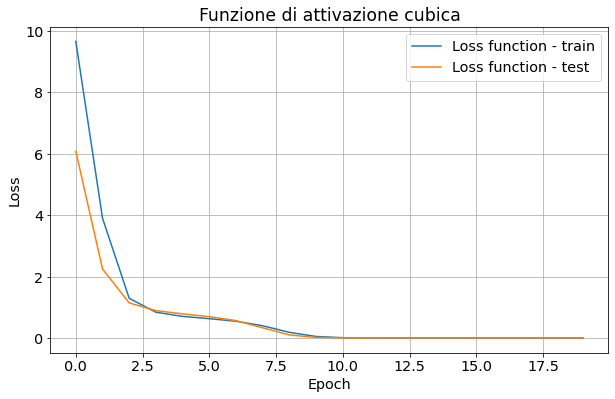

In [34]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.legend(['Loss function - train', 'Loss function - test'], loc='best')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Funzione di attivazione cubica' )

4/4 [==============================] - 0s 726us/step
(100,)
(100,)


Text(0, 0.5, 'y')

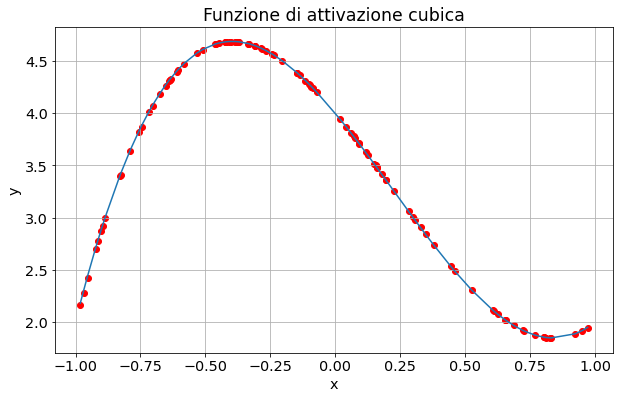

In [35]:
x_predicted = np.random.uniform(-1, 1, 100)
x_predicted.sort()
y_predicted = modelpow.predict(x_predicted).reshape(100)

x_target = np.random.uniform(-1, 1, 100)
x_target.sort()
y_target = 4 - 3*x_predicted - 2*np.power(x_predicted,2) + 3*np.power(x_predicted,3)

print(x_predicted.shape); print(y_predicted.shape);
plt.scatter(x_predicted, y_predicted, color='r')
plt.plot(x_predicted, y_target)
plt.grid(True)
plt.title('Funzione di attivazione cubica')
plt.xlabel('x')
plt.ylabel('y')

Valuto la capacità predittiva del modello al di fuori dell'intervallo di training che mi aspetto superiore rispetto a quella delle reti precedenti con altre funzioni di attivazione.

4/4 [==============================] - 0s 738us/step
(100,)
(100,)


Text(0, 0.5, 'y')

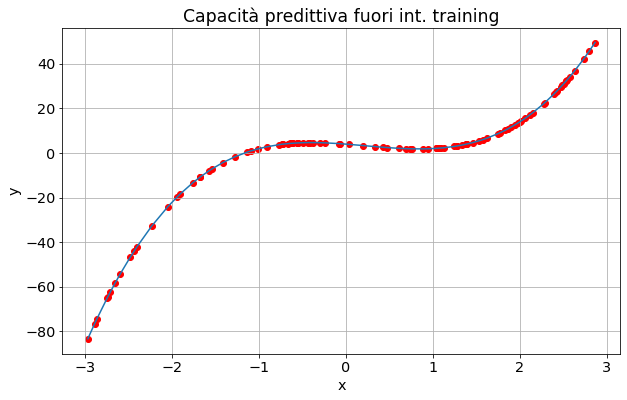

In [36]:
x_predicted = np.random.uniform(-3, 3, 100)
x_predicted.sort()
y_predicted = modelpow.predict(x_predicted).reshape(100)

x_target = np.random.uniform(-3, 3, 100)
x_target.sort()
y_target = 4 - 3*x_predicted - 2*np.power(x_predicted,2) + 3*np.power(x_predicted,3)

print(x_predicted.shape); print(y_predicted.shape);
plt.scatter(x_predicted, y_predicted, color='r')
plt.plot(x_predicted, y_target)
plt.grid(True)
plt.title('Capacità predittiva fuori int. training')
plt.xlabel('x')
plt.ylabel('y')

## Esercizio 3

L'obiettivo di questo esercizio è quello di estendere nuovamente la rete neurale precedente per eseguire il fit di una funzione trigonometrica bidimensionale.
Nello specifico è stata utilizzata la funzione
$$f(x,y) = \sin(x^2 +y^2) $$
con $x \in [-\frac{3}{2}, \frac{3}{2}]$ e $y\in[-\frac{3}{2},\frac{3}{2}]$.

## Generazione dei dati

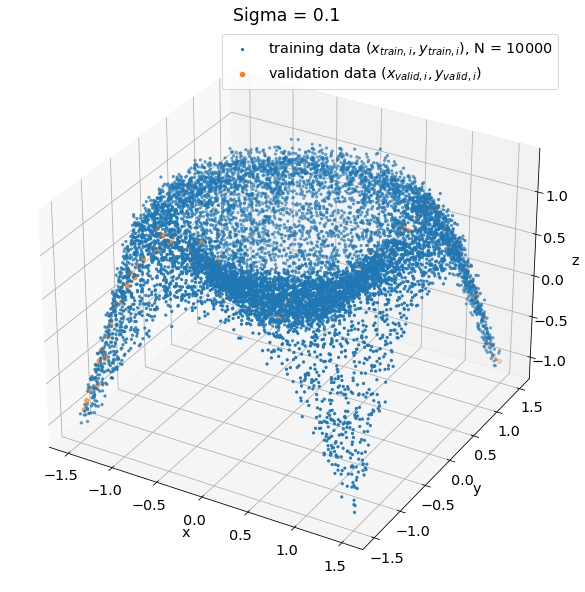

In [37]:
np.random.seed(0)
x_train = np.random.uniform(-3/2, 3/2, 10000) 
x_valid = np.random.uniform(-3/2, 3/2, 100)
x_valid.sort()
x_target = np.random.uniform(-1,1,50)

y_train = np.random.uniform(-3/2, 3/2, 10000)
y_valid = np.random.uniform(-3/2, 3/2, 100)
y_valid.sort()
y_target = np.random.uniform(-1,1,50)

sigma = 0.1
z_train = np.random.normal(np.sin(np.power(x_train,2) + np.power(y_train,2)), sigma) # actual measures from which we want to guess regression parameters
z_valid = np.random.normal(np.sin(np.power(x_valid,2) + np.power(y_valid,2)), sigma)
z_target = np.sin(np.power(x_target,2) + np.power(y_target,2))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x_train, y_train, z_train, marker = '.',  label='training data ($x_{train,i}, y_{train,i}$), N = 10000')
ax.scatter(x_valid, y_valid, z_valid, label='validation data $(x_{valid,i},y_{valid,i})$')
#ax.scatter(x_target, y_target, z_target, label='target data $(x_{target,i},y_{target,i})$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
ax.grid(True)
ax.set_title('Sigma = ' + str(sigma))

fig.set_figheight(15)

In [41]:
model3D = tf.keras.Sequential(
    [
        Dense(5, activation = lambda x: tf.pow(x,2), input_shape=(2,), name = "Dense1" ),
        Dense(5, activation = lambda x: tf.pow(x,2), name="Dense2"),
        Dense(5, activation = lambda x: tf.pow(x,2), name="Dense3"),
        Dense(5, activation = lambda x: tf.pow(x,2), name="Dense4"),
        Dense(1, activation='elu', name="Dense_fin"),
    ]
)

model3D.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mse'])

model3D.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense1 (Dense)              (None, 5)                 15        
                                                                 
 Dense2 (Dense)              (None, 5)                 30        
                                                                 
 Dense3 (Dense)              (None, 5)                 30        
                                                                 
 Dense4 (Dense)              (None, 5)                 30        
                                                                 
 Dense_fin (Dense)           (None, 1)                 6         
                                                                 
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [42]:
x = np.c_[x_train, y_train]
x_val= np.c_[x_valid, y_valid]
print(x.shape)
print(x_val.shape)
history3D = model3D.fit(x = x, y=z_train,
                             batch_size=32,
                             epochs=20,
                             shuffle=True,
                             validation_data=(x_val, z_valid)
                       )

(10000, 2)
(100, 2)
Epoch 1/20
313/313 [==============================] - 0s 789us/step - loss: 74.1737 - mse: 74.1737 - val_loss: 24.7898 - val_mse: 24.7898
Epoch 2/20
313/313 [==============================] - 0s 589us/step - loss: 2.1202 - mse: 2.1202 - val_loss: 4.7575 - val_mse: 4.7575
Epoch 3/20
313/313 [==============================] - 0s 595us/step - loss: 0.7396 - mse: 0.7396 - val_loss: 0.9415 - val_mse: 0.9415
Epoch 4/20
313/313 [==============================] - 0s 600us/step - loss: 0.3525 - mse: 0.3525 - val_loss: 0.2593 - val_mse: 0.2593
Epoch 5/20
313/313 [==============================] - 0s 601us/step - loss: 0.2074 - mse: 0.2074 - val_loss: 0.1489 - val_mse: 0.1489
Epoch 6/20
313/313 [==============================] - 0s 612us/step - loss: 0.1411 - mse: 0.1411 - val_loss: 0.1363 - val_mse: 0.1363
Epoch 7/20
313/313 [==============================] - 0s 606us/step - loss: 0.1104 - mse: 0.1104 - val_loss: 0.1408 - val_mse: 0.1408
Epoch 8/20
313/313 [==================

Text(0.5, 1.0, 'Funzione di attivazione polinomiale')

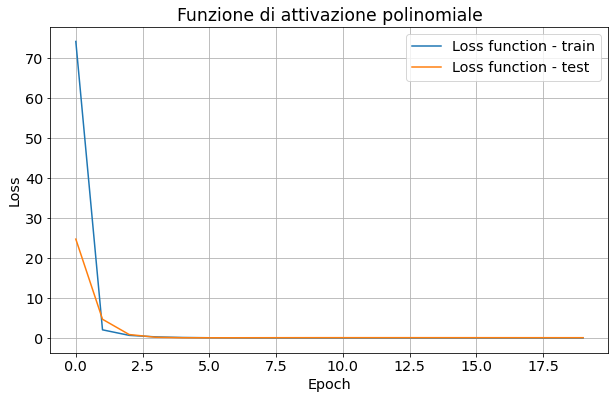

In [43]:
plt.plot(history3D.history['loss'])
plt.plot(history3D.history['val_loss'])
plt.legend(['Loss function - train', 'Loss function - test'], loc='best')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Funzione di attivazione polinomiale' )

32/32 [==============================] - 0s 514us/step
(1000, 1)


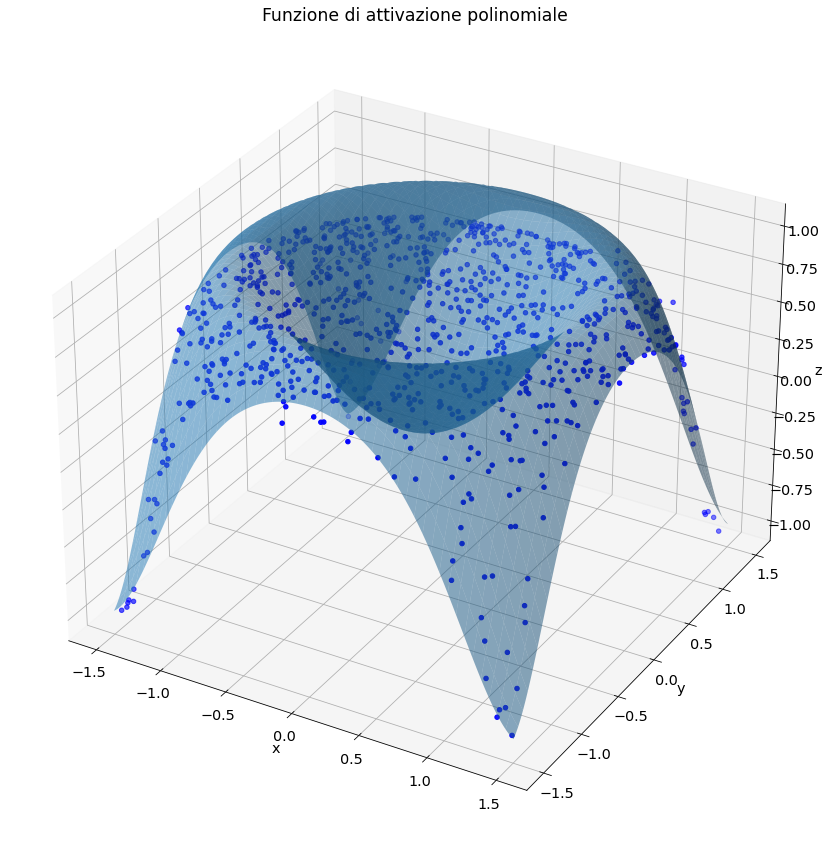

In [45]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_target = np.linspace(-3/2, 3/2, 1000)
y_target = np.linspace(-3/2, 3/2, 1000)
x_target, y_target = np.meshgrid(x_target, y_target)
z_target = np.sin(np.power(x_target,2) + np.power(y_target,2))

x_pred = np.random.uniform(-3/2, 3/2, 1000)
y_pred = np.random.uniform(-3/2, 3/2, 1000)
z_pred = model3D.predict(np.c_[x_pred, y_pred])
print(z_pred.shape)

ax.plot_surface(x_target, y_target, z_target, label='target figure', alpha = 0.5)
ax.scatter(x_pred, y_pred, z_pred, color = 'blue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.grid(True)
ax.set_title('Funzione di attivazione polinomiale')

fig.set_figheight(15)
fig.set_figwidth(15)